In [119]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy import optimize
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import normalize
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go

**data_explanation**<br/> {"CHANNEL": "Channel used to send the packet",<br/>
"CODR" : "Coding rate packet",<br/>
"CREATED AT": "Timestamp indicating the time when the entry has been created inside the database",<br/>
"DATR" :"SF and bandwidth of the packet",<br/>
"DEV_ADDR" :"Unique identifier of the device inside the network",<br/>
"DEV_EUI" : "Unique identifier of the physical device (None if the device is unknown)",<br/>
"FREQUENCY" : "Frequency of the sent packet in MHz",<br/>
"GATEWAY" : "GW MAC ADDRESS which received the packet",<br/>
"LSNR" : "Received signal to noise ratio of the packet",<br/>
"FCNT" : "Frame counter: counter increasing for each packet sent from ED;used evaluate error rate",<br/>
"RSSI" : "Received packet signal strength",<br/>
"SIZE" : "Packet size (bytes)",<br/>
"CRC_STATUS" : "result: if 1 = passed if −1 = failed",<br/>
"TMST" : "Internal clock timestamp from gateway: used for synchronizing the downlink\
        with the end transmission of the uplink to communicate response to end-device",<br/>
"UID" : "Unique identifier of the entry inside the database}"}<br/>

In [2]:
data = pd.read_csv("anonymized_spazio_radio_v2.csv")

In [3]:
def countna():
    nasdict = {}
    for i in data.columns:
        nasdict[i] = [('not na', data[i].notna().sum()),('na', data[i].isna().sum())]
    return nasdict

In [4]:
countna()

{'ant': [('not na', 186632), ('na', 0)],
 'chan': [('not na', 186632), ('na', 0)],
 'codr': [('not na', 186632), ('na', 0)],
 'created_at': [('not na', 186632), ('na', 0)],
 'datr': [('not na', 186632), ('na', 0)],
 'dev_addr': [('not na', 186632), ('na', 0)],
 'dev_eui': [('not na', 186632), ('na', 0)],
 'dev_nonce': [('not na', 5106), ('na', 181526)],
 'freq': [('not na', 186632), ('na', 0)],
 'gateway': [('not na', 186632), ('na', 0)],
 'lsnr': [('not na', 186632), ('na', 0)],
 'ns_time': [('not na', 186632), ('na', 0)],
 'rssi': [('not na', 181526), ('na', 5106)],
 'rssic': [('not na', 186632), ('na', 0)],
 'rssis': [('not na', 176025), ('na', 10607)],
 'rssisd': [('not na', 176025), ('na', 10607)],
 'size': [('not na', 186632), ('na', 0)],
 'time': [('not na', 186622), ('na', 10)],
 'tmms': [('not na', 186622), ('na', 10)],
 'tmst': [('not na', 186632), ('na', 0)],
 'FCnt': [('not na', 181526), ('na', 5106)],
 'valueRaw': [('not na', 186632), ('na', 0)],
 'value_minutes': [('not n

### It is noticable that the number of rows where rssi and rssic are different is the same number of rows of rssi Na

In [5]:
data.codr.unique() #codr has only one value across the data

array(['4/5'], dtype=object)

In [6]:
((data.loc[data['rssi'].notna(),['rssi']]).values ==\
 (data.loc[data['rssi'].notna(),['rssic']]).values).all()
#validating that rssi and rssic have equal values but rssic has no Na's so we drop rssi

True

In [7]:
len(data.dev_eui.unique()) == len(data.dev_addr.unique())

True

In [8]:
data = data.drop(columns = ['dev_nonce']) # has 181526 NA
data = data.drop(columns = ['codr']) #has only one value 
data = data.drop(columns = ['dev_eui']) #mapping one to one with dev_addr
data = data.drop(columns = ['ns_time']) #we drop ns_time because
        #the time of inserting the data inside the database is not relavant to our analysis
data = data.drop(columns = ['rssi']) #duplicated data from rssic
data = data.drop(columns = ['created_at','tmms','value_minutes','tmst',]) 
#duplicated and irrelevant timestamps

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186632 entries, 0 to 186631
Data columns (total 14 columns):
ant         186632 non-null int64
chan        186632 non-null int64
datr        186632 non-null object
dev_addr    186632 non-null object
freq        186632 non-null float64
gateway     186632 non-null object
lsnr        186632 non-null float64
rssic       186632 non-null int64
rssis       176025 non-null float64
rssisd      176025 non-null float64
size        186632 non-null int64
time        186622 non-null object
FCnt        181526 non-null float64
valueRaw    186632 non-null int64
dtypes: float64(5), int64(5), object(4)
memory usage: 19.9+ MB


In [10]:
time = data['time']

In [11]:
#data.time = data.time.values.astype(np.int64) // 10 ** 9   #convert time to unix timestamp

In [12]:
data = data.dropna()

In [13]:
data['size'].unique()

array([64], dtype=int64)

In [14]:
#after dropping Na, Size has only 64
data = data.drop(columns=['size'])

In [15]:
data = data.drop(columns=['time','valueRaw'])

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171198 entries, 0 to 186631
Data columns (total 11 columns):
ant         171198 non-null int64
chan        171198 non-null int64
datr        171198 non-null object
dev_addr    171198 non-null object
freq        171198 non-null float64
gateway     171198 non-null object
lsnr        171198 non-null float64
rssic       171198 non-null int64
rssis       171198 non-null float64
rssisd      171198 non-null float64
FCnt        171198 non-null float64
dtypes: float64(5), int64(3), object(3)
memory usage: 15.7+ MB


In [17]:
data.head()

,ant,chan,datr,dev_addr,freq,gateway,lsnr,rssic,rssis,rssisd,FCnt
0,1,23,SF12BW125,000000ff,868.5,7276FF002E061495,-18.0,-108,-126.0,0.0,190.0
1,0,6,SF12BW125,00000043,868.3,7276FF002E061495,12.0,-93,-93.0,0.0,149.0
2,1,23,SF12BW125,00000013,868.5,7276FF002E061495,14.0,-90,-90.0,0.0,207.0
3,1,21,SF12BW125,00000117,868.1,7276FF002E061495,-20.0,-108,-129.0,0.0,99.0
4,1,21,SF12BW125,00000055,868.1,7276FF002E061495,-6.0,-107,-115.0,0.0,161.0


In [18]:
categorical = ['datr','dev_addr','gateway','chan','ant','freq']
numeric= ['FCnt','lsnr','rssic','rssis','rssisd']

In [19]:
x_cat = data.loc[:,categorical]
x_num = data.loc[:,numeric]

In [20]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import StandardScaler

#standardizing numeric data for scale
scaler = StandardScaler()
x_num = scaler.fit_transform(x_num)

#label encoding for dev_addr
enc_l = LabelEncoder()
enc_l.fit(x_cat['dev_addr'])
dev_labels = enc_l.transform(x_cat['dev_addr'])

#one hot encoding for the rest
enc_cat = OneHotEncoder()
enc_cat.fit(x_cat.loc[:,x_cat.columns != 'dev_addr'])

#Transform
onehotlabels = enc_cat.transform(x_cat.loc[:,x_cat.columns != 'dev_addr']).toarray()
onehotlabels.shape

(171198, 19)

In [21]:
dev_labels = dev_labels.reshape((171198,1))

In [22]:
X = np.append(dev_labels,values = onehotlabels,axis=1)

In [23]:
X.shape

(171198, 20)

In [24]:
X = np.append(X,values = x_num,axis = 1)

In [25]:
X.shape

(171198, 25)

In [27]:
av = np.zeros((len(np.unique(dev_labels)),X.shape[1]-1))
for i in range(len(np.unique(dev_labels))):
    max_fcnt = [max(X[X[:,0]==i][:,20])]
    average = np.mean(X[X[:,0]==i][:,21:25],axis=0)
    mode_cat = stats.mode(X[X[:,0]==i][:,1:20])
    appended1 = np.append(max_fcnt,values=average,axis=0)
    appended2 = np.append(mode_cat.mode,values=appended1.reshape(1,appended1.shape[0]),axis=1)
    av[i] = appended2

In [28]:
av.shape

(290, 24)

In [29]:
wcss=[]
dbs=[]
for i in range(2,31): 
    kmeans = KMeans(n_clusters=i,\
                    random_state=0,n_jobs=6 ).fit(av)
#inertia_ : Sum of squared distances of samples to their closest cluster center.
    wcss.append(kmeans.inertia_)
    labels = kmeans.labels_
    dbs.append(davies_bouldin_score(av, labels))
    print('clustering with k = {} done!'.format(i))

clustering with k = 2 done!
clustering with k = 3 done!
clustering with k = 4 done!
clustering with k = 5 done!
clustering with k = 6 done!
clustering with k = 7 done!
clustering with k = 8 done!
clustering with k = 9 done!
clustering with k = 10 done!
clustering with k = 11 done!
clustering with k = 12 done!
clustering with k = 13 done!
clustering with k = 14 done!
clustering with k = 15 done!
clustering with k = 16 done!
clustering with k = 17 done!
clustering with k = 18 done!
clustering with k = 19 done!
clustering with k = 20 done!
clustering with k = 21 done!
clustering with k = 22 done!
clustering with k = 23 done!
clustering with k = 24 done!
clustering with k = 25 done!
clustering with k = 26 done!
clustering with k = 27 done!
clustering with k = 28 done!
clustering with k = 29 done!
clustering with k = 30 done!


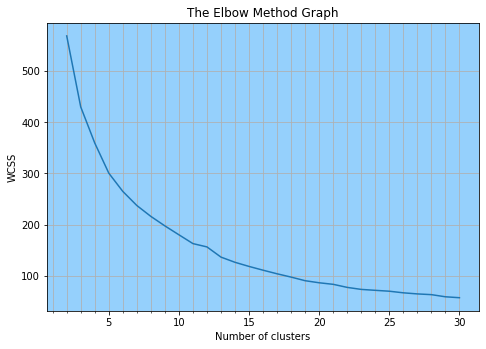

In [30]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
major_ticks = np.arange(0, 31, 5)
minor_ticks = np.arange(0, 31, 1)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.set_facecolor('xkcd:light blue')
plt.plot(np.arange(2,31),wcss)
ax.set_title("The Elbow Method Graph")
ax.set_xlabel('Number of clusters')
ax.set_ylabel('WCSS')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

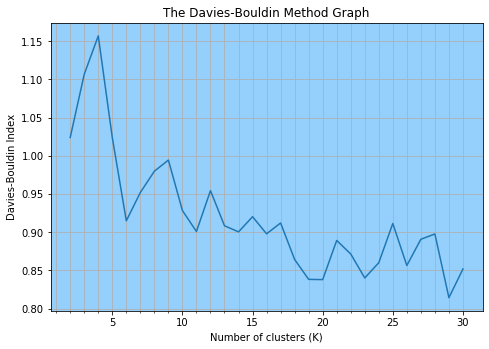

In [31]:
#Plot the Davies-Bouldin graph
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
major_ticks = np.arange(0, 31, 5)
minor_ticks = np.arange(0, 31, 1)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.set_facecolor('xkcd:light blue')
plt.plot(range(2,31),dbs)
plt.title('The Davies-Bouldin Method Graph')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Davies-Bouldin Index')
plt.show

In [32]:
kmeans = KMeans(n_clusters=13)

In [33]:
model = kmeans.fit(av)
clusters = model.predict(av).reshape((len(av),1))

In [34]:
labeled = np.append(av,clusters,axis=1)

In [35]:
labeled.shape

(290, 25)

In [36]:
labeled = np.insert(labeled,obj=0,values=np.sort(np.unique(dev_labels)),axis = 1)

In [37]:
labeled.shape

(290, 26)

In [38]:
cols = ['dev_addr']
onehotcols = list(np.random.rand(onehotlabels.shape[1]))
cols.extend(onehotcols)
cols.extend(numeric)
cols.append('label')

In [39]:
labeled_df = pd.DataFrame(labeled,columns=cols)

In [40]:
labeled_df

,dev_addr,0.15394564867910687,0.05943354142393076,0.1511631412398915,0.18577857934004882,0.2792414253741268,0.6106646261731582,0.2404994145593271,0.5326223539936666,0.9656463960201249,...,0.34155381928856676,0.016708494059887058,0.0742351250846387,0.46367809777717106,FCnt,lsnr,rssic,rssis,rssisd,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.433996,-0.862896,-0.547238,-0.784467,0.173129,10.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,2.436859,0.497344,0.228180,0.423612,-0.117777,6.0
2,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.871328,0.330226,0.036975,0.255438,-0.023791,6.0
3,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,-1.325275,-0.484304,-0.740058,-0.619246,0.270053,0.0
4,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.305797,0.822705,0.827236,0.803414,-0.088822,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,285.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,-1.356614,-1.859759,-0.722894,-1.689529,0.977562,9.0
286,286.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,-1.318152,-1.770899,-0.714907,-1.591516,0.754598,9.0
287,287.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,-0.396494,-1.512697,-0.520576,-1.282932,0.307848,9.0
288,288.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.790124,-0.589954,-0.453361,-0.537011,0.056161,5.0


In [41]:
inversed = enc_cat.inverse_transform(labeled_df.iloc[:,1:20].values)
categorical.remove('dev_addr')
inversed = pd.DataFrame(inversed,columns=categorical)

In [42]:
inversed

,datr,gateway,chan,ant,freq
0,SF10BW125,7276FF002E061495,5,0,868.1
1,SF7BW125,7276FF002E061495,5,1,868.1
2,SF7BW125,7276FF002E061495,5,1,868.1
3,SF8BW125,7276FF002E061495,5,1,868.1
4,SF7BW125,7276FF002E061495,5,0,868.1
...,...,...,...,...,...
285,SF12BW125,7276FF002E061495,5,1,868.1
286,SF12BW125,7276FF002E061495,5,1,868.1
287,SF12BW125,7276FF002E061495,5,1,868.1
288,SF10BW125,7276FF002E061495,5,1,868.1


In [43]:
todrop = list(labeled_df.columns)[1:20]
labeled_df = labeled_df.drop(columns=todrop)
labeled_df = labeled_df.join(inversed)
labeled_df[numeric] = scaler.inverse_transform(labeled_df[numeric])
labeled_df[numeric]= labeled_df[numeric].astype(int)
labeled_df.dev_addr= labeled_df.dev_addr.astype(int)
labeled_df.dev_addr = enc_l.inverse_transform(labeled_df.dev_addr)

In [44]:
labeled_df

,dev_addr,FCnt,lsnr,rssic,rssis,rssisd,label,datr,gateway,chan,ant,freq
0,00000000,1446,-11,-106,-119,0,10.0,SF10BW125,7276FF002E061495,5,0,868.1
1,00000001,2852,1,-101,-105,0,6.0,SF7BW125,7276FF002E061495,5,1,868.1
2,00000002,2455,0,-103,-107,0,6.0,SF7BW125,7276FF002E061495,5,1,868.1
3,00000003,211,-7,-108,-117,0,0.0,SF8BW125,7276FF002E061495,5,1,868.1
4,00000004,2058,4,-97,-101,0,4.0,SF7BW125,7276FF002E061495,5,0,868.1
...,...,...,...,...,...,...,...,...,...,...,...,...
285,0000011d,189,-21,-107,-129,0,9.0,SF12BW125,7276FF002E061495,5,1,868.1
286,0000011e,216,-20,-107,-128,0,9.0,SF12BW125,7276FF002E061495,5,1,868.1
287,0000011f,863,-17,-106,-124,0,9.0,SF12BW125,7276FF002E061495,5,1,868.1
288,00000120,1696,-8,-106,-116,0,5.0,SF10BW125,7276FF002E061495,5,1,868.1


In [45]:
labeled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 12 columns):
dev_addr    290 non-null object
FCnt        290 non-null int32
lsnr        290 non-null int32
rssic       290 non-null int32
rssis       290 non-null int32
rssisd      290 non-null int32
label       290 non-null float64
datr        290 non-null object
gateway     290 non-null object
chan        290 non-null object
ant         290 non-null object
freq        290 non-null object
dtypes: float64(1), int32(5), object(6)
memory usage: 21.6+ KB


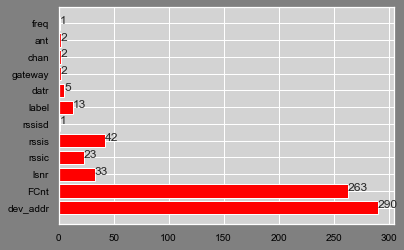

In [80]:
x = ["dev_addr", "FCnt", "lsnr", "rssic", "rssis", "rssisd", "label", "datr", "gateway", "chan", "ant", "freq"]
y = [
    len(labeled_df['dev_addr'].unique()),
    len(labeled_df['FCnt'].unique()),
    len(labeled_df['lsnr'].unique()),
    len(labeled_df['rssic'].unique()),
    len(labeled_df['rssis'].unique()),
    len(labeled_df['rssisd'].unique()),
    len(labeled_df['label'].unique()),
    len(labeled_df['datr'].unique()),
    len(labeled_df['gateway'].unique()),
    len(labeled_df['chan'].unique()),
    len(labeled_df['ant'].unique()),
    len(labeled_df['freq'].unique()),
    ]
plt.barh(x, y)

for index, value in enumerate(y):
    plt.text(value, index, str(value))

In [60]:
labeled_df[labeled_df['label'] == 7]

,dev_addr,FCnt,lsnr,rssic,rssis,rssisd,label,datr,gateway,chan,ant,freq
11,0000000b,2270,7,-87,-89,0,7.0,SF7BW125,7276FF002E061495,5,0,868.1
23,00000017,2620,8,-93,-95,0,7.0,SF7BW125,7276FF002E061495,5,0,868.1
27,0000001b,1990,8,-92,-94,0,7.0,SF7BW125,7276FF002E061495,5,0,868.1
30,0000001e,2440,7,-95,-97,0,7.0,SF7BW125,7276FF002E061495,5,0,868.1
41,00000029,2205,8,-93,-94,0,7.0,SF7BW125,7276FF002E061495,5,0,868.1
52,00000034,2947,8,-91,-93,0,7.0,SF7BW125,7276FF002E061495,5,0,868.1
74,0000004a,2431,11,-85,-86,0,7.0,SF7BW125,7276FF002E061495,5,0,868.1
82,00000052,3171,11,-91,-91,0,7.0,SF7BW125,7276FF002E061495,5,1,868.1
114,00000072,2982,11,-88,-89,0,7.0,SF7BW125,7276FF002E061495,5,0,868.1
143,0000008f,2982,7,-96,-98,0,7.0,SF7BW125,7276FF002E061495,5,0,868.1


In [61]:
labeled_df['rssisd'].unique()

array([0], dtype=int64)

In [255]:
fig = px.scatter(labeled_df, x='label',y='dev_addr',
                color='datr', size_max=100,
                opacity=0.9)
fig.show()

In [63]:
labeled_df['gateway'].unique()

array(['7276FF002E061495', '7276FF002E050264'], dtype=object)

In [89]:
count_series = labeled_df.groupby(['gateway']).size()

In [90]:
count_series

gateway
7276FF002E050264     14
7276FF002E061495    276
dtype: int64

In [105]:
fig = px.scatter(labeled_df, x='gateway',y='dev_addr',
                color='label', size_max=100,
                opacity=0.9)
fig.show()

In [104]:
fig = px.scatter_3d(labeled_df, x='dev_addr', y='gateway', z='rssic',
                color='label', size_max=100,
                opacity=0.9)
fig.show()

In [106]:
fig = px.scatter(labeled_df, x='label', y='rssic',
                size_max=100,
                opacity=0.9)
fig.show()

In [103]:
fig = px.scatter(labeled_df, x='label', y='lsnr',
                size_max=100,
                opacity=0.9)
fig.show()

In [102]:
fig = px.scatter(labeled_df, x='label', y='FCnt',
                size_max=100,
                opacity=0.9)
fig.show()

In [66]:
fig = px.scatter(labeled_df, x='FCnt', y='lsnr',
                color='label', size_max=100,
                opacity=0.9)
fig.show()

In [197]:
fig = px.scatter_3d(labeled_df, x='lsnr', y='rssic', z='FCnt',
                color='label', size_max=100,
                opacity=0.9)
fig.show()

In [67]:
fig = px.scatter(labeled_df, x='dev_addr', y='lsnr',
                color='label', size_max=100,
                opacity=0.9)
fig.show()

In [68]:
fig = px.scatter_3d(labeled_df, x='dev_addr', y='rssis', z='rssic',
                color='label', size_max=100,
                opacity=0.9)
fig.show()

In [69]:
fig = px.scatter_3d(labeled_df, x='lsnr', y='rssic', z='FCnt',
                color='label', size_max=100,
                opacity=0.9)
fig.show()

In [70]:
fig = px.scatter_3d(labeled_df, x='rssisd', y='rssis', z='rssic',
                color='label', size_max=100,
                opacity=0.9)
fig.show()

In [71]:
fig = px.scatter_3d(labeled_df[labeled_df['label'] == 0], x='rssis', y='lsnr', z='rssic',size='FCnt',size_max=15,
              opacity=1,color='datr')
fig.show()

In [72]:
color = ["#ff0000", "#0073e6", "#ff751a", "#00ff00", "#e6e600", "#ff00ff","#0000e6",\
         "#006622", "#804000", "#6600ff", "#b30000", "#66ffff","#4d2600"]

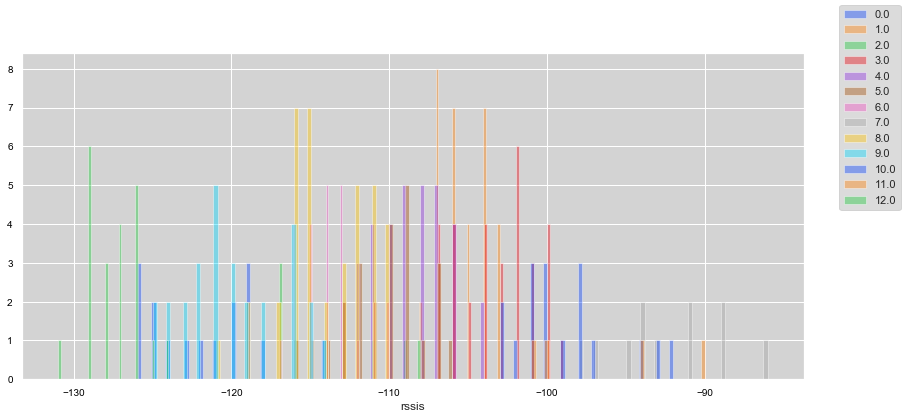

In [199]:
fig = plt.figure(figsize=(14,6))
sns.set(rc={'axes.facecolor':'lightgrey', 'figure.facecolor':'white','xtick.color':'black','ytick.color':'black'\
          , 'xtick.labelsize':'10', 'ytick.labelsize':'10'})
sns.set_palette("bright")
for i in labeled_df['label'].unique():
    sns.distplot(labeled_df[labeled_df['label']==i]['rssis'],label='label',kde=False,bins=40)
fig.legend(labels=np.sort(labeled_df['label'].unique()))

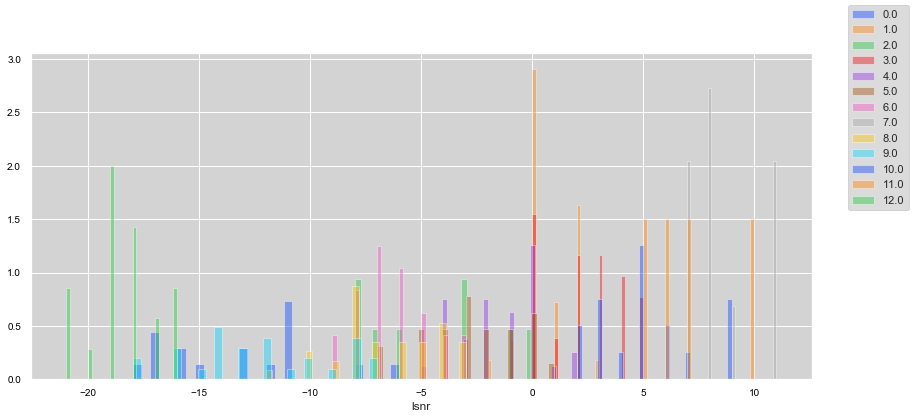

In [200]:
fig = plt.figure(figsize=(14,6))
sns.set(rc={'axes.facecolor':'lightgrey', 'figure.facecolor':'white','xtick.color':'black','ytick.color':'black'\
          , 'xtick.labelsize':'10', 'ytick.labelsize':'10'})
sns.set_palette("bright")
for i in labeled_df['label'].unique():
    sns.distplot(labeled_df[labeled_df['label']==i]['lsnr'],label='label',kde=False,bins=30,norm_hist=True)
fig.legend(labels=np.sort(labeled_df['label'].unique()))

In [74]:
data = pd.merge(data,pd.DataFrame(labeled_df[['dev_addr','label']]),on = 'dev_addr')

In [218]:
data.head()

,ant,chan,datr,dev_addr,freq,gateway,lsnr,rssic,rssis,rssisd,FCnt,label
0,1,23,SF12BW125,000000ff,868.5,7276FF002E061495,-18.0,-108,-126.0,0.0,190.0,3.0
1,1,22,SF12BW125,000000ff,868.3,7276FF002E061495,-23.0,-103,-127.0,1.0,191.0,3.0
2,1,21,SF12BW125,000000ff,868.1,7276FF002E061495,-18.0,-108,-127.0,0.0,192.0,3.0
3,1,22,SF12BW125,000000ff,868.3,7276FF002E061495,-18.0,-108,-127.0,0.0,202.0,3.0
4,1,23,SF12BW125,000000ff,868.5,7276FF002E061495,-23.0,-106,-129.0,0.0,204.0,3.0


In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171198 entries, 0 to 171197
Data columns (total 12 columns):
ant         171198 non-null int64
chan        171198 non-null int64
datr        171198 non-null object
dev_addr    171198 non-null object
freq        171198 non-null float64
gateway     171198 non-null object
lsnr        171198 non-null float64
rssic       171198 non-null int64
rssis       171198 non-null float64
rssisd      171198 non-null float64
FCnt        171198 non-null float64
label       171198 non-null float64
dtypes: float64(6), int64(3), object(3)
memory usage: 17.0+ MB


### number of packet sent

In [211]:
labels_packet_number = data.groupby(['label']).size().to_dict()

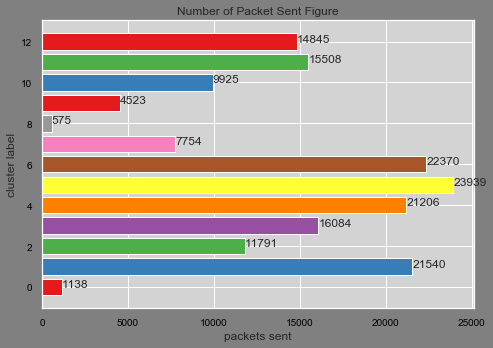

In [239]:
x = list(labels_packet_number.keys())
y = list(labels_packet_number.values())

fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0,0,1,1])
ax.barh(x, y,color = color)
plt.title('Number of Packet Sent Figure')
plt.ylabel('cluster label')
plt.xlabel('packets sent')
for index, value in enumerate(y):
    plt.text(value, index, str(value))

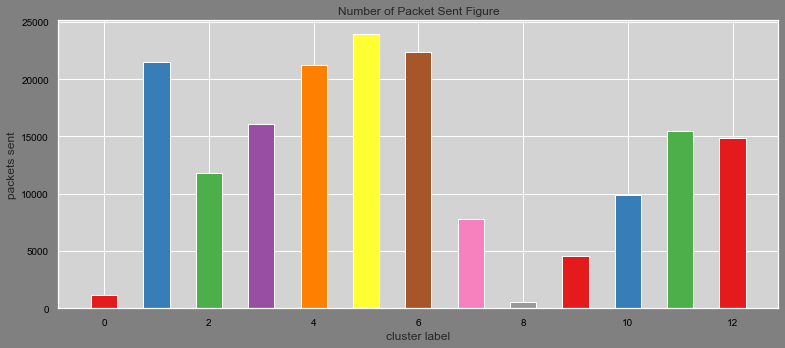

In [206]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])
ax.bar(*zip(*labels_packet_number.items()),color= color, width = 0.5)
plt.title('Number of Packet Sent Figure')
plt.xlabel('cluster label')
plt.ylabel('packets sent')
plt.show()

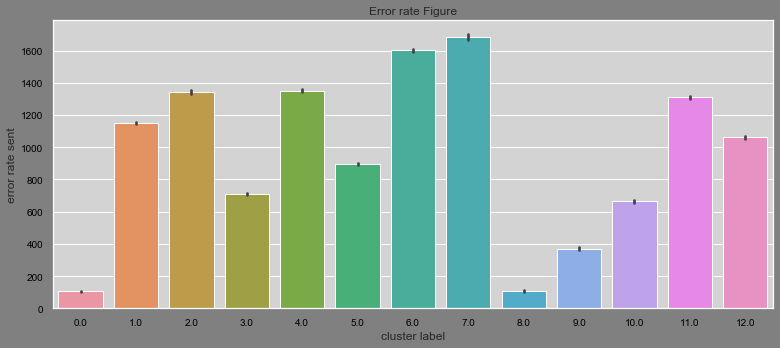

In [248]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])
ax = sns.barplot(x="label", y="FCnt", data=data)
plt.title('Error rate Figure')
plt.xlabel('cluster label')
plt.ylabel('error rate sent')
plt.show()

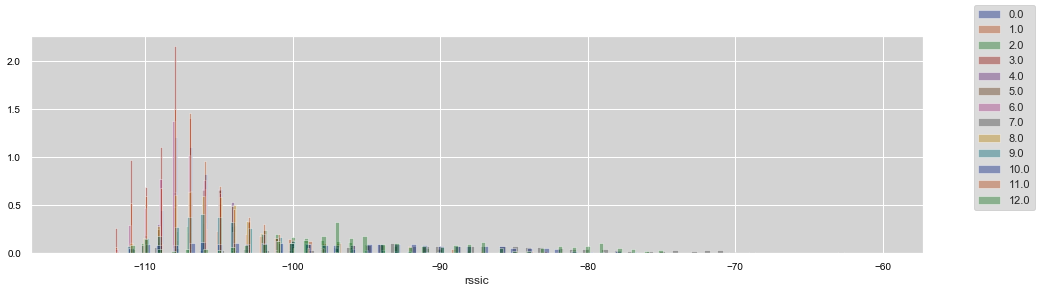

In [204]:
fig = plt.figure(figsize=(16,4))
sns.set(rc={'axes.facecolor':'lightgrey', 'figure.facecolor':'grey','xtick.color':'black','ytick.color':'black'\
          , 'xtick.labelsize':'10', 'ytick.labelsize':'10'})

sns.set_palette("dark")

for i in data['label'].unique():
        sns.distplot(data[data['label']==i]['rssic'],label='label',kde=False,bins=120,norm_hist=True)
fig.legend(labels=np.sort(data['label'].unique()))

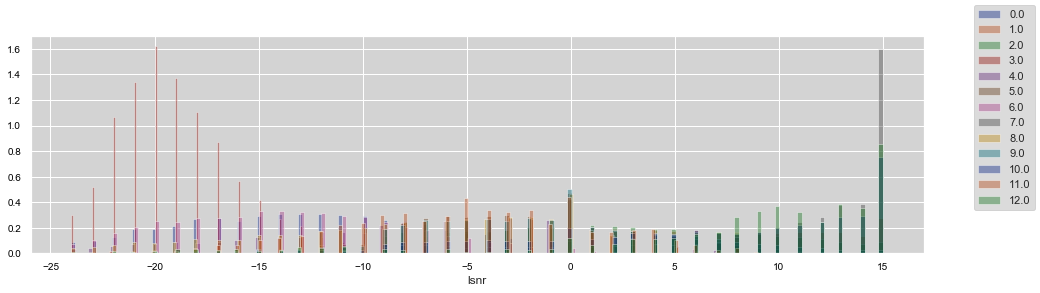

In [203]:
fig = plt.figure(figsize=(16,4))
sns.set(rc={'axes.facecolor':'lightgrey','xtick.color':'black','ytick.color':'black'\
          , 'xtick.labelsize':'10', 'ytick.labelsize':'10'})
sns.set_palette("dark")
for i in data['label'].unique():
        sns.distplot(data[data['label']==i]['lsnr'],label='label',kde=False,bins=180,norm_hist=True)
fig.legend(labels=np.sort(data['label'].unique()))